Next: https://github.com/arunarn2/HierarchicalAttentionNetworks/blob/master/HierarchicalAttn.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

In [33]:
from keras import backend as K
from keras.models import Model, Input, load_model
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Lambda, \
                         Activation, CuDNNLSTM, SpatialDropout1D, Dropout, BatchNormalization,\
                         GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.optimizers import RMSprop, Adam, Adamax, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras.layers.merge import add
from keras.utils import to_categorical

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

#### Custom Functions

In [6]:
from src.callbacks import PlotCurves
from src.eval_metrics import f1_macro, f1_micro # Many-to-one does not return a sequential y_preds.
from src.load_data import load_data

### Load Data

In [7]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [8]:
ww = 2
n_tags = 2
batch_size = 32

In [9]:
def get_input(data_, ww, n_tags, batch_size, is_test=False, limit=None):
    
    def normalize(text):
        return text.replace('\n', '').strip()
    
    padding_sent = {
        'sentence': 'ENDPAD',
        'label': 0
    }

    X = []
    y = []

    for article in data_:
        sent_objs = article['sentences']
        
        for si, sentence in enumerate(sent_objs):
            sequence = []

            # Prev
            for i in reversed(range(ww)):
                sequence.append(normalize(sent_objs[si-i-1]['sentence']) 
                                if si-i-1 >= 0 
                                else padding_sent['sentence'])

            # Curr
            sequence.append(normalize(sent_objs[si]['sentence']))

            # Next
            for i in range(ww):
                sequence.append(normalize(sent_objs[si+i+1]['sentence'] )
                                if si+i+1 < len(article['sentences']) 
                                else padding_sent['sentence'])

            X.append(sequence)
            y.append(sent_objs[si]['label']
                     if is_test 
                     else to_categorical(sent_objs[si]['label'], num_classes=n_tags))
            
    # limit data if not an even number when batch_size=2
    if not limit:
        limit = len(X) if len(X)%batch_size == 0 else len(X)-len(X)%batch_size
        X = X[:limit]
        y = y[:limit]

    return np.array(X), np.array(y)

In [22]:
X_tra, y_tra = get_input(train_data, ww, n_tags, batch_size, False)
X_val, y_val = get_input(valid_data, ww, n_tags, batch_size, False)
X_test, y_test = get_input(test_data, ww, n_tags, batch_size, True)

In [23]:
X_tra.shape, X_val.shape, X_test.shape

((3552, 5), (384, 5), (416, 5))

In [24]:
y_tra.shape, y_val.shape, y_test.shape

((3552, 2), (384, 2), (416,))

### Load ELMo

In [25]:
sess = tf.compat.v1.Session()
K.set_session(sess)

In [26]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

## Build Model

In [27]:
def ELMoEmbeddingStack(x):
    """
    ELMo takes list of sentences (as strings) and returns list of vectors.
    Thus when an article is given to elmo(), it returns a vector for each sentence.
    
    >> elmo(['I saw a cat.', 'There was also a dog.'])
    [<1024>, <1024>]
    """
    embeds = []
    for art in tf.unstack(tf.transpose(x, (1, 0))):
        embeds.append(elmo(tf.squeeze(tf.cast(art, tf.string)), signature="default", as_dict=True)["default"])
    return tf.stack(embeds, 1)

In [ ]:
def build_model_0(ww, n_tags):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")
    
    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Bidirectional(CuDNNLSTM(units=256, return_sequences=True))(embedding)
                      
    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_1(ww, n_tags):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")
    
    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Bidirectional(CuDNNLSTM(units=128, return_sequences=True))(embedding)

    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_2(ww, n_tags):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")
    
    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Bidirectional(CuDNNLSTM(units=256, return_sequences=True))(embedding)
    x = Dropout(0.2)(x)
                      
    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_3(ww, n_tags):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")
    
    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    
    x = Bidirectional(LSTM(units=128, return_sequences=True))(x)

    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_4(ww, n_tags):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")

    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    
    x = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(x)

    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

In [28]:
def build_model_5(ww, n_tags):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")

    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Bidirectional(CuDNNLSTM(units=128, return_sequences=True))(embedding)
    x = Bidirectional(CuDNNLSTM(units=128, return_sequences=True))(x)
    x = Dropout(0.4)(x)
    
    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)



def build_model_6(ww, n_tags):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")

    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Bidirectional(CuDNNLSTM(units=256, return_sequences=True))(embedding)
    x = Bidirectional(CuDNNLSTM(units=128, return_sequences=True))(x)
    x = Dropout(0.4)(x)
    
    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_7(ww, n_tags):
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")

    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Bidirectional(CuDNNLSTM(units=128, return_sequences=True))(embedding)
    x = Bidirectional(CuDNNLSTM(units=128, return_sequences=True))(x)
    
    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_8(ww, n_tags):
    
    def residual(x):
        x_res = x
        
        x = Bidirectional(CuDNNLSTM(units=128, return_sequences=True))(x)
        x = add([x, x_res])
        return x
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")

    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Bidirectional(CuDNNLSTM(units=128, return_sequences=True))(embedding)
    x = residual(x)

    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)


def build_model_9(ww, n_tags):
    
    def residual(x):
        x_res = x
        
        x = Bidirectional(CuDNNLSTM(units=256, return_sequences=True))(x)
        x = add([x, x_res])
        return x
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")
    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Bidirectional(CuDNNLSTM(units=256, return_sequences=True))(embedding)
    x = residual(x)

    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_10(ww, n_tags):
    
    def residual(x):
        x_res = x
        
        x = Bidirectional(CuDNNLSTM(units=256, return_sequences=True))(x)
        x = add([x, x_res])
        return x
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")
    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Bidirectional(CuDNNLSTM(units=256, return_sequences=True))(embedding)
    x = residual(x)
    x = Dropout(0.4)(x)

    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)



def build_model_11(ww, n_tags):
    
    def residual(x):
        x_res = x
        
        x = Bidirectional(CuDNNLSTM(units=128, return_sequences=True))(x)
        x = add([x, x_res])
        return x
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")

    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)

    x = Bidirectional(CuDNNLSTM(units=128, return_sequences=True))(embedding)
    x = residual(x)

    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_12(ww, n_tags):
    
    def residual(x):
        x_res = x

        x = Bidirectional(CuDNNLSTM(units=256, return_sequences=True))(x)
        x = add([x, x_res])
        return x

    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")

    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
                                
    x = Bidirectional(CuDNNLSTM(units=256, return_sequences=True))(x)
    x = residual(x)

    pred = LSTM(n_tags, activation="sigmoid")(x)

    return Model(inputs=[input_text], outputs=pred)

def build_model_13(ww, n_tags):
    
    def residual(x):
        x_res = x
        
        x = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)

        x = add([x, x_res])
        return x
    
    inp_size = 2*ww+1
    input_text = Input(shape=(inp_size,), dtype="string")
    embedding = Lambda(ELMoEmbeddingStack, output_shape=(None, None, inp_size, 1024))(input_text)    
    x = Dense(256, activation='relu')(embedding)
    x = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(x)

    x = residual(x)

    pred = LSTM(n_tags, activation="sigmoid")(x)
    
    return Model(inputs=[input_text], outputs=pred)

In [29]:
learningrate=0.001
optimizer = Adam(lr=learningrate)
optimizer_str = 'adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [30]:
model = build_lstm_model(ww, n_tags)
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, None, None, 5 0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, None, None, 5 524800      lambda_3[0][0]                   
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, None, None, 5 131328      dense_5[0][0]                    
__________________________________________________________________________________________________
bidirectio

In [31]:
model_name = 'RQ2_elmo_many_to_one_model_0' + \
             '_ww_' + str(ww) + \
             '_' + optimizer_str + \
             '_lr_' + str(learningrate) + \
             '_lrreduction' + \
             '_loss_' + loss

model_dir = './Model/' + model_name.split('model')[0] + 'model/' + model_name
results_file = os.path.join(model_dir, 'model_results_file.txt')

### Train Model

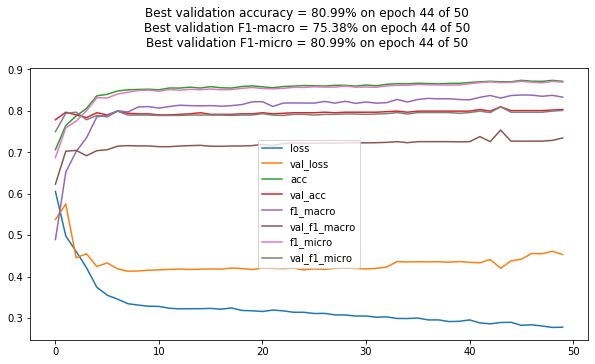

In [32]:
model.fit(X_tra, y_tra, 
          epochs=50, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val), 
          callbacks=[
              PlotCurves(model_name=model_name, model_dir=model_dir, jnote=True),
              ReduceLROnPlateau(monitor='val_f1_macro', patience=3, 
                                factor=0.1, min_lr=0.00001),
              EarlyStopping(monitor='val_f1_macro', min_delta=0, patience=10, mode='max')
          ])

### Load the best Model

In [ ]:
model_name

In [ ]:
best_model = load_model(os.path.join(model_dir, model_name + '_best_f1_macro_model.h5'), 
                        custom_objects={'elmo':elmo, 'tf':tf, 'f1_macro':f1_macro, 'f1_micro':f1_micro})

### Evaluation

In [25]:
def get_scores(model, data_, batch_size, ww, n_tags, results_file):
    
    X, y = get_input(data_, ww, n_tags, batch_size, is_test=True, limit=None)
    
    y_preds = model.predict(X, batch_size=batch_size)
    y_preds = np.argmax(y_preds, axis=1)
    
    clsrpt = classification_report(y, y_preds)
    sfm = scikit_f1_score(y, y_preds, average='macro')

    print(clsrpt)
    print('\nScikit_F1_Macro:', sfm)

    if results_file:
        with open(results_file, 'a') as f:
            f.write('\n' + clsrpt + '\n' + str(sfm) + '\n\n')

#### Validation Set

In [26]:
with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')

In [27]:
get_scores(best_model, valid_data, batch_size, ww, n_tags, results_file)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       268
           1       0.00      0.00      0.00       130

   micro avg       0.67      0.67      0.67       398
   macro avg       0.34      0.50      0.40       398
weighted avg       0.45      0.67      0.54       398


Scikit_F1_Macro: 0.40240240240240244


/home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Test Set

In [28]:
with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')

In [29]:
get_scores(best_model, test_data, batch_size, ww, n_tags, results_file)

              precision    recall  f1-score   support

           0       0.74      1.00      0.85       325
           1       0.00      0.00      0.00       115

   micro avg       0.74      0.74      0.74       440
   macro avg       0.37      0.50      0.42       440
weighted avg       0.55      0.74      0.63       440


Scikit_F1_Macro: 0.42483660130718953
